# 以识别手写数字为例，构建两层LSTM网络，实验主为 explorer 其内部黑盒结构，使用tensorflow API
  #### 将原来 784 维的像素点图，按行序输入，序列长fix 为 28 
  #### 并行的批次超参在训练和测试时consistant 5
  #### LSTM内隐藏前馈层神经元out 各层都 fix 256
  #### 多分类激活用softmax
  #### 损失用交叉熵，其产生背景及原理此处不细数

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data


import warnings
warnings.filterwarnings('ignore')  


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


mnist = input_data.read_data_sets(r'..\MNIST_data',one_hot=True)
print(mnist.train.images.shape)


#####################
# (55000, 784)
# [Finished in 11.4s]
#####################



#设置模型的超参数: 输入输出，层数，每层的隐藏节点数，最后的分类数

lr= 1e-3
input_size=28
timestep_size=28
hidden_size=256
layer_num=2
class_num=10
cell_type="lstm"

X_input = tf.placeholder(tf.float32,[None,784])
y_input = tf.placeholder(tf.float32,[None,class_num])

#训练和测试的时候，我们想用不同的 batch_size,所以采用占位符的方式
batch_size=tf.placeholder(tf.int32,[]) 
keep_prob=tf.placeholder(tf.float32,[])


X = tf.reshape(X_input,[-1,28,28])


def lstm_cell(cell_type,num_nodes,keep_prob):
	cell=tf.contrib.rnn.BasicLSTMCell(num_nodes)
	cell=tf.contrib.rnn.DropoutWrapper(cell,output_keep_prob=keep_prob)
	return cell

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(cell_type,hidden_size,keep_prob) for _ in range(layer_num)],state_is_tuple=True)



#用全零来初始化state
init_state = mlstm_cell.zero_state(batch_size,dtype=tf.float32)

## 利用cell class 的__call__()函数，
outputs=list()
state = init_state
with tf.variable_scope('RNN'):
	for timestamp in range(timestep_size):
		(cell_output,state) = mlstm_cell(X[:,timestamp,:],state)
		outputs.append(cell_output)

h_state = outputs[-1]


import time 
# 开始训练和测试

W = tf.Variable(tf.truncated_normal([hidden_size,class_num],stddev=0.1),dtype=tf.float32)
bias = tf.Variable(tf.constant(1/class_num,shape=[class_num]),dtype=tf.float32)

y_pre = tf.nn.softmax(tf.matmul(h_state,W)+bias)

# 损失和评估函数

cross_entropy = -tf.reduce_mean(y_input*tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1),tf.argmax(y_input,1))
accuracy= tf.reduce_mean(tf.cast(correct_prediction,"float"))

sess.run(tf.global_variables_initializer())

time0 = time.time()

for i in range(100):
	_batch_size=100
	X_batch,y_batch = mnist.train.next_batch(batch_size=_batch_size)
	cost,acc,_ = sess.run([cross_entropy,accuracy,train_op],feed_dict={X_input:X_batch,y_input:y_batch,keep_prob:1.0,batch_size:_batch_size})
	if (i+1) % 50 ==0:
		#分 5 次进行批处理
		test_acc = 0.0
		test_cost = 0.0
		N = 10
		for j in range(N):
			X_batch,y_batch = mnist.train.next_batch(batch_size=_batch_size)
			_cost,_acc = sess.run([cross_entropy,accuracy],feed_dict={X_input:X_batch,y_input:y_batch,keep_prob:1.0,batch_size:_batch_size})
			test_cost += _cost
			test_acc += _acc
		print("step {},train_cost={:.6f},acc={:.6f},test_cost={:.6f},test_acc={:.6f}; pass {} s".format(i+1,cost,acc,test_cost/N,test_acc/N,time.time()-time0))
		time0 = time.time()


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:\GitHub\example-notebook\MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:\GitHub\example-notebook\MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting E:\GitHub\example-notebook\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting E:\GitHub\example-notebook\MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code wi

In [2]:
_batch_size=5
X_batch,y_batch = mnist.test.next_batch(_batch_size)
print(X_batch.shape,y_batch.shape)

(5, 784) (5, 10)


In [3]:
_outputs,_state = np.array(sess.run([outputs,state],feed_dict={X_input:X_batch,y_input:y_batch,keep_prob:1.0,batch_size:_batch_size}))
print("_outputs.shape=",np.asarray(_outputs).shape)
print("_state.shape=",np.asarray(_state).shape)

_outputs.shape= (28, 5, 256)
_state.shape= (2, 2, 5, 256)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


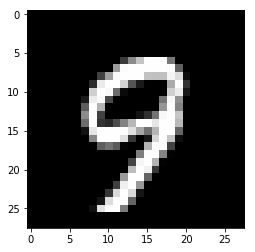

In [7]:
% matplotlib inline
import matplotlib.pyplot as plt

print(mnist.train.labels[10:20])


X3 = mnist.train.images[10]
img3 = X3.reshape([28,28])
plt.imshow(img3,cmap='gray')
plt.show()

In [8]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            X_input: X3, y_input: y_batch, keep_prob: 1.0, batch_size: 1}))
print(X3_outputs.shape)
X3_outputs.shape = [28, hidden_size]
print(X3_outputs.shape)

(28, 1, 256)
(28, 256)


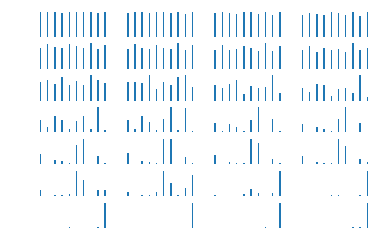

In [9]:
h_W, h_bias = sess.run([W, bias], feed_dict={
            X_input:X3, y_input: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = h_bias.reshape([-1, 10])

bar_index = range(class_num)
for i in range(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()